In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from summer2 import CompartmentalModel
from summer2.parameters import Parameter

In [2]:
def build_seir_demog_model(
    config: dict,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = ("Susceptible", "Pre-infectious", "Infectious", "Immune")
    model = CompartmentalModel(
        times=(0., config["end_time"] * 365.),
        compartments=compartments,
        infectious_compartments=["Infectious"],
    )
    model.set_initial_population(
        distribution={
            "Susceptible": config["tot_popn"] - config["infectious_seed"],
            "Infectious": config["infectious_seed"],
        }
    )
    
    # Transitions
    ave_infous = Parameter("ave_infous")
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("r0") / ave_infous,
        source="Susceptible", 
        dest="Pre-infectious"
    )
    model.add_transition_flow(
        name="progression", 
        fractional_rate=1. / Parameter("ave_preinfous"),
        source="Pre-infectious", 
        dest="Infectious"
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=1. / ave_infous,
        source="Infectious", 
        dest="Immune"
    )
    model.add_universal_death_flows(
        "universal_death",
        death_rate=1. / Parameter("life_expectancy") / 365.
    )
    model.add_replacement_birth_flow(
        "births",
        "Susceptible"
    )

    # Output
    model.request_output_for_flow(
        name="incidence", 
        flow_name="progression"
    )
    
    return model

In [3]:
model_config = {
    "tot_popn": 1e5,
    "infectious_seed": 1.,
    "end_time": 100.,
}

parameters = {
    "r0": 13.,
    "ave_preinfous": 8.,
    "ave_infous": 7.,
    "life_expectancy": 70.,
}

In [4]:
seir_demog_model = build_seir_demog_model(model_config)
seir_demog_model.run(parameters=parameters, solver="euler")

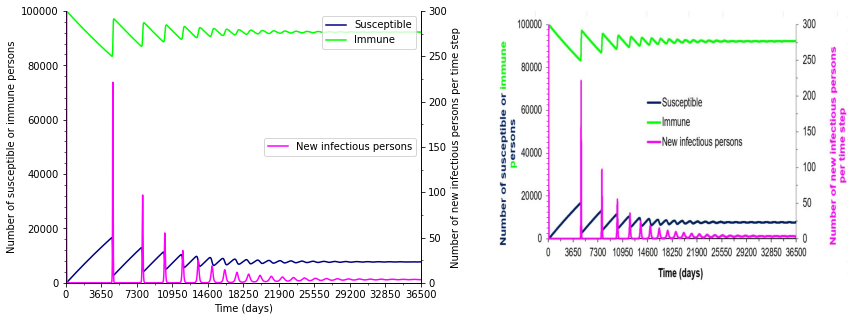

In [5]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

left_ax.plot(
    seir_demog_model.times, 
    seir_demog_model.get_outputs_df()["Susceptible"], 
    color="navy", 
    label="Susceptible",
)
left_ax.plot(
    seir_demog_model.times, 
    seir_demog_model.get_outputs_df()["Immune"], 
    color="lime", 
    label="Immune",
)
left_ax.set_xlim(0., 36500.)
left_ax.set_xticks(range(0, 40150, 3650))
left_ax.xaxis.set_minor_locator(AutoMinorLocator(2))
left_ax.set_xlabel("Time (days)")
left_ax.set_ylim(0., 1e5)
left_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
left_ax.set_ylabel("Number of susceptible or immune persons")
left_ax.legend(loc=1)
left_ax.spines.top.set_visible(False)

twin_ax = left_ax.twinx()
twin_ax.plot(
    seir_demog_model.times, 
    seir_demog_model.derived_outputs["incidence"], 
    color="magenta", 
    label="New infectious persons",
)
twin_ax.set_ylim(0., 300.)
twin_ax.yaxis.set_minor_locator(AutoMinorLocator(2))
twin_ax.set_ylabel("Number of new infectious persons per time step")
twin_ax.legend(loc=5)
twin_ax.spines.top.set_visible(False)

image = plt.imread("./figures/model_3_2_fig.JPG")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");